In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

colors_ = ["blue", "red", "green", "gray", "black"]

import pylib.mix as mix
import pylib.measurement as mse

25226
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(100):
    plt.close()

path_qucf_ = "../QuCF/simulations/MI/sin"
name_qucf_pr_   = "MI"
name_qucf_file_ = name_qucf_pr_ + "_OUTPUT.hdf5"
path_save_plots_ = "./tools/QSVT-angles/inversion/saved-plots/"

   nx 	12
   alpha_k0 	-1.570796326795e+00
   alpha_k1 	1.571179915641e+00


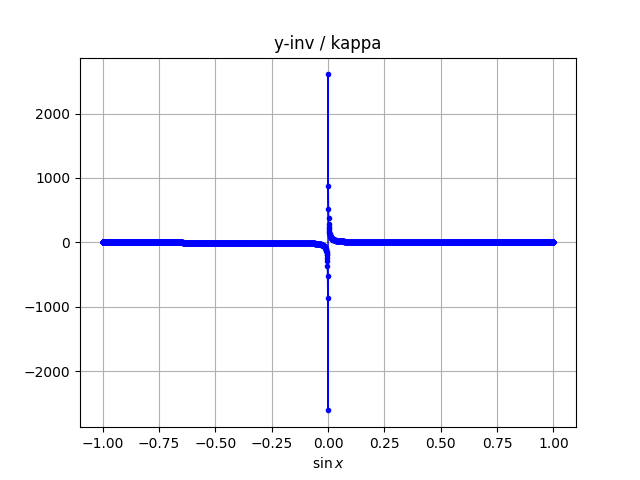

In [95]:
# ------------------------------------------------------------------
# --- Create a reference matrix ---
# ------------------------------------------------------------------
def prepare_ref(xmax):
    # --- Original matrix ---
    
    # --- x grid ---
    Nx_ = 1 << nx_
    x_ = np.linspace(-xmax, xmax, Nx_)

    # --- matrix whose singular values encode the function ---
    y = np.sin(x_)
    A_ = np.diag(y)

    # --- reference inverse function ---
    y_inv_ref_ = 1. / y

    # --- SIN parameters ---
    alpha_k0 = - xmax 
    alpha_k1 = np.abs(alpha_k0) * Nx_ /(Nx_  - 1)
    print("   nx \t{:d}".format(nx_))
    print("   alpha_k0 \t{:0.12e}".format(alpha_k0))
    print("   alpha_k1 \t{:0.12e}".format(alpha_k1))

    # --- Plotting the initial function ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.sin(x_), y_inv_ref_, color='b', marker = ".", linewidth = 1, linestyle='-')
    plt.xlabel('$\sin{x}$')
    plt.title("y-inv / kappa")
    plt.grid(True)
    plt.show()

    return x_, Nx_, A_, y_inv_ref_
# --------------------------------------------------------------
# nx_, kappa_qucf_ = 7, 1e2
# nx_, kappa_qucf_ = 8, 2e2
# nx_, kappa_qucf_ = 9, 5e2
# nx_, kappa_qucf_ = 10, 1e3
# nx_, kappa_qucf_ = 11, 1.5e3
nx_, kappa_qucf_ = 12, 3e3
# nx_, kappa_qucf_ = 13, 6e3
# nx_, kappa_qucf_ = 14, 1.2e4
# nx_, kappa_qucf_ = 15, 2.3e4

flag_full_ = True

if flag_full_:
    xmax_ = np.pi/2.       # FULL x grid
else:
    xmax_ = np.arcsin(0.99)

x_, Nx_, A_, y_inv_ref_ = prepare_ref(xmax_)

In [78]:
# ----------------------------------------------------------
# --- Compute the condition number ---
# ----------------------------------------------------------
from numpy import linalg as LA
def compute_kappa():
    evals, evecs = LA.eig(A_)
    kappa = np.max(np.abs(evals)) / np.min(np.abs(evals))
    print("nx: \t{:d}".format(nx_))
    print("cond. number: {:0.1f}".format(kappa))
    return
# ----------------------------------------------------------------
compute_kappa()


nx: 	7
cond. number: 80.9


Reading the file ../QuCF/simulations/MI/sin/results//MI_nx12_k3.0e3_FULL_OUTPUT.hdf5...
Name of the simulation is MI
Simulation has been performed  08-06-2024 10:24:09

QSVT kappa: 3.0e+03

max. relative err: 7.240e-04


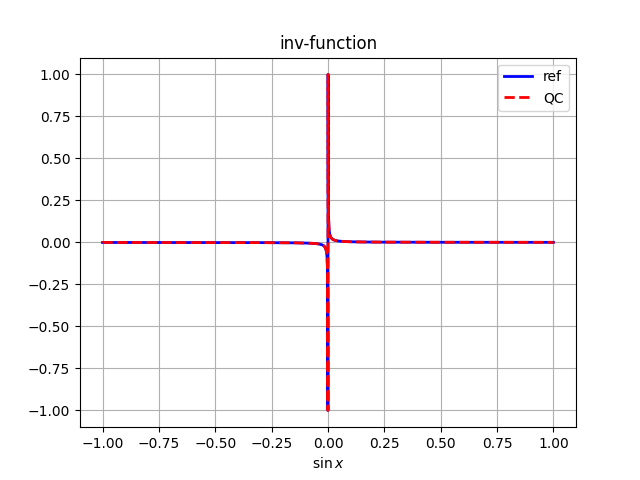

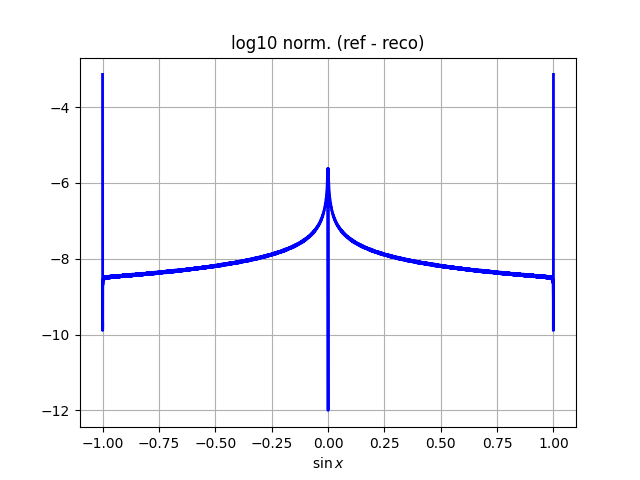

write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_sin_ref_k3.0e3_FULL.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_sin_reco_k3.0e3_FULL.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_sin_err_x_k3.0e3_FULL.dat


In [96]:
# -------------------------------------------------
# --- Compare with QuCF simulations ---
# -------------------------------------------------
mix.reload_module(mse)
def compare_with_qucf(kappa, flag_read_loc, flag_full, flag_adv, flag_save):
    # --- Reading QC data ---
    km, ke = mix.get_order_base10(kappa)
    str_k = "{:0.1f}e{:d}".format(km, ke)
    pr_name = "MI_nx{:d}_k{:s}".format(nx_, str_k)

    str_full = ""
    if not flag_read_loc:
        path_res = path_qucf_ + "/results/"
        if flag_adv:
            pr_name += "_ADV"
        if flag_full:
            str_full = "_FULL"
            pr_name += str_full
    else:
        path_res = path_qucf_ 
        pr_name = name_qucf_pr_

    om = mse.MeasOracle__(True)
    om.path_  = path_res
    om.pname_ = pr_name
    om.open()

    # --- QSVT parameter ---
    om.read_qsvt()
    kappa_qc = om.dd_["qsvt_mi"]["par"]
    if np.abs(kappa_qc - kappa) > 1e-4:
        print()
        print("<<< ERROR: a wrong QSVT parameter.>>>")
        print()
    print()
    print("QSVT kappa: {:0.1e}".format(kappa_qc))


    # --- Normalize the reference case ---
    y_ref_norm = y_inv_ref_ / kappa

    # --- QuCF data ---
    om.set_zero_ancillae_work_states(0)
    qc_data_all = om.get_var_x({}, "rs")

    y_inv_qc_ = qc_data_all.imag  # correct global phase;

    y_inv_qc_ *= 2**(nx_/2.) / om.dd_["qsvt_mi"]["rescaling_factor"]
    if y_inv_qc_[0] > 0:
        y_inv_qc_ *= -1 # correct global phase;

    # --- Normalize everything to 1 ---
    y_ref_norm /= np.max(np.abs(y_ref_norm))
    y_inv_qc_ /= np.max(np.abs(y_inv_qc_))

    # --- Relative error ---
    norm_diff = y_ref_norm - y_inv_qc_
    max_rel_err = np.max(np.abs(norm_diff))

    log_norm_diff = np.zeros(Nx_)
    for ix in range(Nx_):
        v = np.abs(norm_diff[ix])
        if v < 1e-12:
            v = 1e-12
        log_norm_diff[ix] = np.log10(v)
    print()
    print("max. relative err: {:0.3e}".format(max_rel_err))

    # --- Plotting: comparison ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        np.sin(x_), y_ref_norm, 
        color='b', linewidth = 2, linestyle='-',  
        label = "ref"
    )
    ax.plot(
        np.sin(x_), y_inv_qc_,
        color='r', linewidth = 2, linestyle='--',  
        label = "QC"
    )
    plt.xlabel('$\sin{x}$')
    plt.title("inv-function")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Plotting: error ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.sin(x_), log_norm_diff, color='b', linewidth = 2, linestyle='-')
    plt.xlabel('$\sin{x}$')
    plt.title("log10 norm. (ref - reco)")
    plt.grid(True)
    plt.show()

    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_sin_ref_k{:s}{:s}.dat".format(str_k, str_full),
            np.sin(x_), y_ref_norm
        )
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_sin_reco_k{:s}{:s}.dat".format(str_k, str_full),
            np.sin(x_), y_inv_qc_
        )
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_sin_err_x_k{:s}{:s}.dat".format(str_k, str_full), 
            np.sin(x_), log_norm_diff
        )
    return
# ----------------------------------------------------------
compare_with_qucf(
    kappa = kappa_qucf_,
    flag_read_loc = False,
    flag_full = flag_full_,
    flag_adv = False,
    flag_save = True
)

In [3]:
# --------------------------------------------------------
# --- Scan condition number versus nx ---
# --------------------------------------------------------
def save_scan():
    nx_array = [   7,     8,     9,    10,     11,     12,     13,     14,      15]
    k__array = [88.0, 176.6, 354.0, 708.6, 1417.9, 2836.5, 5673.6, 11348.0, 22696.6]
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_sin_kappa_nx.dat", 
        nx_array, k__array
    )
    return
# ------------------------------------------------------------------------------
def save_max_rel_error():
    nx_array = [         7,         8,         9,        10,        11,        12,        13,       14,         15]
    k__array  = [     88.0,     176.6,     354.0,     708.6,    1417.9,    2836.5,    5673.6,   11348.0,   22696.6]
    err_array = [1.887e-05, 7.999e-06, 6.715e-07, 7.241e-07, 2.069e-06, 2.982e-06, 3.402e-06, 3.610e-06, 4.135e-06]
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_sin_err_nx.dat", 
        k__array, np.log10(err_array)
    )
    return
# ------------------------------------------------------------------------------
save_scan()
save_max_rel_error()

write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_sin_kappa_nx.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_sin_err_nx.dat
